# Tesla (TSLA) Stock Price Prediction — LSTM, BiLSTM & GRU 📈

**Overview (in simple English):**

This notebook teaches you how to predict Tesla's (TSLA) **next-day closing price** using three recurrent neural network types: **LSTM**, **Bidirectional LSTM (BiLSTM)**, and **GRU**. The notebook is written step-by-step with detailed Markdown explanations so even a beginner or a high-school student can follow. You will download historical data from Yahoo Finance, explore the data, prepare it for time-series modeling, build and train models, evaluate them, and visualize predictions.

**Data range:** `2015-01-01` to today (2025-10-14). Adjust dates as needed.

---

**What you will learn:**

- How to download stock data using `yfinance`.
- How to prepare time-series sequences (sliding windows).
- How to build three simple recurrent architectures (LSTM, BiLSTM, GRU).
- How to train models with early stopping and checkpoints.
- How to evaluate models using MAE, RMSE, and MAPE.
- How to visualize actual vs predicted prices.

---

**How to run:** Execute cells sequentially. If you lack internet on your machine, replace the data-download cell with a local CSV containing Tesla historical prices.


In [8]:
## 1) Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# reproducibility
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print('Libraries loaded')


Libraries loaded


## 2) Download TSLA historical data

We'll download daily Tesla stock prices (ticker `TSLA`) using `yfinance`. We'll use the **Close** price as the main target for this example. The time window is from **2015-01-01** to today.

In [9]:
# Download
start = '2025-01-01'
end = '2025-10-14'

df = yf.download('TSLA', start=start, end=end)
df.head()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23800\2221225139.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TSLA', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-01-02,379.279999,392.730011,373.040009,390.100006,109710700
2025-01-03,410.440002,411.880005,379.450012,381.480011,95423300
2025-01-06,411.049988,426.429993,401.700012,423.200012,85516500
2025-01-07,394.359985,414.329987,390.000000,405.829987,75699500
2025-01-08,394.940002,402.500000,387.399994,392.950012,73038800


## 3) Quick EDA

Let's inspect the data for missing values and visualize the closing price trend. Observing the plot helps you understand the volatility and trends the models must learn.

Shape: (195, 5)

Missing values:
 Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


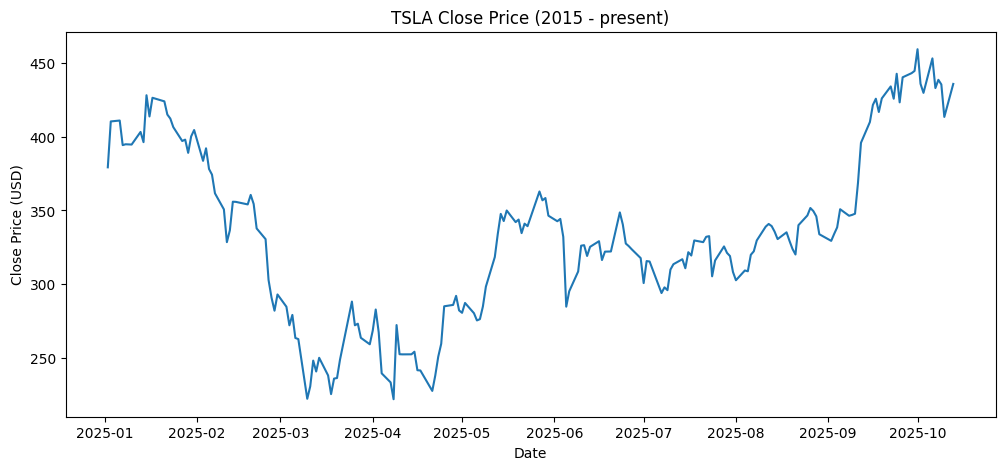

In [10]:
# Basic info
print('Shape:', df.shape)
print('\nMissing values:\n', df.isna().sum())

# Plot Close price
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'])
plt.title('TSLA Close Price (2015 - present)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.show()


In [11]:
import os
SEQ_LEN = 60         # how many past days we feed to predict next day
FUTURE_DAYS = 30     # forecast horizon for final demo
TEST_RATIO = 0.15
VAL_RATIO = 0.10
BATCH = 32
EPOCHS = 30
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [12]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].copy()
data = data.ffill().dropna()   # forward fill then drop remaining NaNs if any
print("After ffill shape:", data.shape)

After ffill shape: (195, 5)


In [13]:
import joblib
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)   # shape (n_days, 5)
# Save scaler to reuse in deployment
joblib.dump(scaler, os.path.join(MODEL_DIR, "tesla_multiple_input_scaler.gz"))
print("Scaler saved.")

Scaler saved.


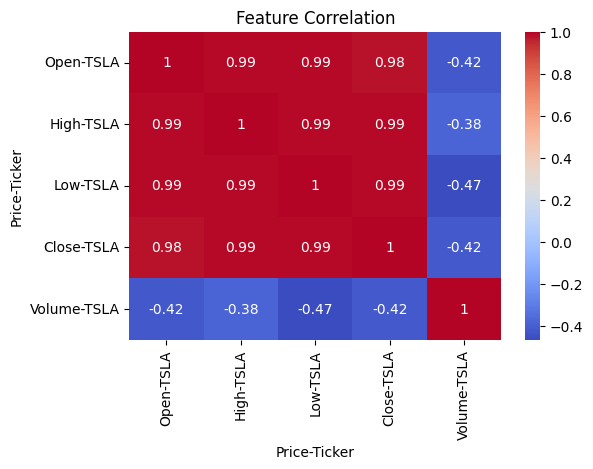

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()  # shape (n_samples, 1)

In [16]:
# Cell 8 — create sequences (multivariate)
def create_multivariate_sequences(scaled_array, seq_len):
    X, y = [], []
    for i in range(seq_len, len(scaled_array)):
        X.append(scaled_array[i-seq_len:i, :])   # seq_len x n_features
        # target: next-day close (column index for 'Close' is 3 in our features)
        y.append(scaled_array[i, features.index('Close')])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_all, y_all = create_multivariate_sequences(scaled_data, SEQ_LEN)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)


X_all shape: (135, 60, 5) y_all shape: (135,)


## 4) Preprocessing

We'll use the **Close** column only (univariate forecasting). Steps:

1. Keep `Close` column and scale it with `MinMaxScaler` to range [0,1].
2. Create sliding windows (lookback/sequence length = 60 days) so each sample uses 60 past days to predict the next day.
3. Split into time-ordered train/validation/test sets (80% train, 10% val, 10% test).


### 4.1) Time-based train/validation/test split

We keep chronological order: first 80% for training, next 10% validation, final 10% test.


In [17]:
# Cell 9 — time-aware split
n = len(X_all)
test_size = int(n * TEST_RATIO)
val_size = int(n * VAL_RATIO)

train_end = n - test_size - val_size
val_end = n - test_size

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (102, 60, 5) (102,)
Val:   (13, 60, 5) (13,)
Test:  (20, 60, 5) (20,)


## 5) Model building: LSTM, BiLSTM, GRU

We'll create simple, comparable architectures for the three model types. Keep them compact so they train reasonably fast on a laptop/GPU.

In [18]:
# Cell 10 — Helper build functions (simple & clear models)
def build_lstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_bilstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape),
        Dropout(dropout),
        Bidirectional(LSTM(units//2)),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_gru(input_shape, units=64, dropout=0.2):
    m = Sequential([
        GRU(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        GRU(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m


## 6) Train models

We will train each model with early stopping and save the best weights using ModelCheckpoint. Training on CPUs may take time; reduce epochs if needed.

In [19]:
# Cell 11 — training helper
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
def compile_and_train(model, name, X_train, y_train, X_val, y_val, epochs=EPOCHS):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint(os.path.join(MODEL_DIR, f"{name}.h5"), monitor='val_loss', save_best_only=True, verbose=1)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=BATCH, callbacks=callbacks, verbose=2)
    return history


In [20]:
# Cell 12 — Build & train LSTM (simple)
input_shape = (X_train.shape[1], X_train.shape[2])
lstm = build_lstm(input_shape, units=128, dropout=0.2)
lstm_hist = compile_and_train(lstm, "lstm_multifeature", X_train, y_train, X_val, y_val)

c:\Users\ASUS\miniforge3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30

Epoch 1: val_loss improved from None to 0.32067, saving model to saved_models\lstm_multifeature.h5


4/4 - 6s - 2s/step - loss: 0.1866 - mae: 0.4008 - val_loss: 0.3207 - val_mae: 0.5577 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.32067 to 0.23094, saving model to saved_models\lstm_multifeature.h5


4/4 - 1s - 158ms/step - loss: 0.1349 - mae: 0.3374 - val_loss: 0.2309 - val_mae: 0.4708 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.23094 to 0.15555, saving model to saved_models\lstm_multifeature.h5


4/4 - 1s - 139ms/step - loss: 0.0917 - mae: 0.2739 - val_loss: 0.1556 - val_mae: 0.3830 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.15555 to 0.09515, saving model to saved_models\lstm_multifeature.h5


4/4 - 1s - 161ms/step - loss: 0.0569 - mae: 0.2116 - val_loss: 0.0952 - val_mae: 0.2943 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 0.09515 to 0.05049, saving model to saved_models\lstm_multifeature.h5


4/4 - 1s - 143ms/step - loss: 0.0321 - mae: 0.1517 - val_loss: 0.0505 - val_mae: 0.2056 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss improved from 0.05049 to 0.02320, saving model to saved_models\lstm_multifeature.h5


4/4 - 1s - 161ms/step - loss: 0.0198 - mae: 0.1145 - val_loss: 0.0232 - val_mae: 0.1236 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss improved from 0.02320 to 0.01194, saving model to saved_models\lstm_multifeature.h5


4/4 - 1s - 163ms/step - loss: 0.0127 - mae: 0.0910 - val_loss: 0.0119 - val_mae: 0.0718 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: val_loss improved from 0.01194 to 0.00966, saving model to saved_models\lstm_multifeature.h5


4/4 - 1s - 168ms/step - loss: 0.0172 - mae: 0.1053 - val_loss: 0.0097 - val_mae: 0.0632 - learning_rate: 1.0000e-04
Epoch 9/30

Epoch 9: val_loss did not improve from 0.00966
4/4 - 1s - 139ms/step - loss: 0.0155 - mae: 0.1023 - val_loss: 0.0108 - val_mae: 0.0674 - learning_rate: 1.0000e-04
Epoch 10/30

Epoch 10: val_loss did not improve from 0.00966
4/4 - 0s - 125ms/step - loss: 0.0138 - mae: 0.0943 - val_loss: 0.0141 - val_mae: 0.0814 - learning_rate: 1.0000e-04
Epoch 11/30

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 11: val_loss did not improve from 0.00966
4/4 - 1s - 145ms/step - loss: 0.0127 - mae: 0.0887 - val_loss: 0.0186 - val_mae: 0.1036 - learning_rate: 1.0000e-04
Epoch 12/30

Epoch 12: val_loss did not improve from 0.00966
4/4 - 0s - 121ms/step - loss: 0.0133 - mae: 0.0895 - val_loss: 0.0208 - val_mae: 0.1133 - learning_rate: 5.0000e-05
Epoch 13/30

Epoch 13: val_loss did not improve from 0.00966
4/4 - 1s - 136ms/step - loss: 0.0131 - 

In [21]:
# Cell 13 — Build & train BiLSTM
bilstm = build_bilstm(input_shape, units=128, dropout=0.2)
bilstm_hist = compile_and_train(bilstm, "bilstm_multifeature", X_train, y_train, X_val, y_val)

c:\Users\ASUS\miniforge3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30

Epoch 1: val_loss improved from None to 0.28571, saving model to saved_models\bilstm_multifeature.h5


4/4 - 13s - 3s/step - loss: 0.2292 - mae: 0.4462 - val_loss: 0.2857 - val_mae: 0.5258 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.28571 to 0.14077, saving model to saved_models\bilstm_multifeature.h5


4/4 - 1s - 206ms/step - loss: 0.1298 - mae: 0.3262 - val_loss: 0.1408 - val_mae: 0.3632 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.14077 to 0.05376, saving model to saved_models\bilstm_multifeature.h5


4/4 - 1s - 174ms/step - loss: 0.0617 - mae: 0.2234 - val_loss: 0.0538 - val_mae: 0.2127 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.05376 to 0.01587, saving model to saved_models\bilstm_multifeature.h5


4/4 - 1s - 174ms/step - loss: 0.0328 - mae: 0.1521 - val_loss: 0.0159 - val_mae: 0.0874 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 0.01587 to 0.00822, saving model to saved_models\bilstm_multifeature.h5


4/4 - 1s - 175ms/step - loss: 0.0308 - mae: 0.1337 - val_loss: 0.0082 - val_mae: 0.0629 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss did not improve from 0.00822
4/4 - 1s - 145ms/step - loss: 0.0318 - mae: 0.1350 - val_loss: 0.0082 - val_mae: 0.0743 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss improved from 0.00822 to 0.00815, saving model to saved_models\bilstm_multifeature.h5


4/4 - 1s - 173ms/step - loss: 0.0273 - mae: 0.1231 - val_loss: 0.0082 - val_mae: 0.0633 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: val_loss did not improve from 0.00815
4/4 - 1s - 148ms/step - loss: 0.0199 - mae: 0.1104 - val_loss: 0.0103 - val_mae: 0.0646 - learning_rate: 1.0000e-04
Epoch 9/30

Epoch 9: val_loss did not improve from 0.00815
4/4 - 1s - 147ms/step - loss: 0.0129 - mae: 0.0901 - val_loss: 0.0124 - val_mae: 0.0731 - learning_rate: 5.0000e-05
Epoch 10/30

Epoch 10: val_loss did not improve from 0.00815
4/4 - 1s - 145ms/step - loss: 0.0125 - mae: 0.0843 - val_loss: 0.0143 - val_mae: 0.0812 - learning_rate: 5.0000e-05
Epoch 11/30

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 11: val_loss did not improve from 0.00815
4/4 - 1s - 145ms/step - loss: 0.0116 - mae: 0.0845 - val_loss: 0.0160 - val_mae: 0.0892 - learning_rate: 5.0000e-05
Epoch 12/30

Epoch 12: va

In [22]:
# Cell 14 — Build & train GRU
gru = build_gru(input_shape, units=128, dropout=0.2)
gru_hist = compile_and_train(gru, "gru_multifeature", X_train, y_train, X_val, y_val)

Epoch 1/30

Epoch 1: val_loss improved from None to 0.14802, saving model to saved_models\gru_multifeature.h5


4/4 - 7s - 2s/step - loss: 0.0882 - mae: 0.2696 - val_loss: 0.1480 - val_mae: 0.3743 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.14802 to 0.09005, saving model to saved_models\gru_multifeature.h5


4/4 - 1s - 144ms/step - loss: 0.0529 - mae: 0.2062 - val_loss: 0.0901 - val_mae: 0.2873 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.09005 to 0.04947, saving model to saved_models\gru_multifeature.h5


4/4 - 1s - 143ms/step - loss: 0.0280 - mae: 0.1436 - val_loss: 0.0495 - val_mae: 0.2057 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.04947 to 0.02509, saving model to saved_models\gru_multifeature.h5


4/4 - 1s - 144ms/step - loss: 0.0181 - mae: 0.1100 - val_loss: 0.0251 - val_mae: 0.1350 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 0.02509 to 0.01328, saving model to saved_models\gru_multifeature.h5


4/4 - 1s - 142ms/step - loss: 0.0100 - mae: 0.0775 - val_loss: 0.0133 - val_mae: 0.0846 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss improved from 0.01328 to 0.00901, saving model to saved_models\gru_multifeature.h5


4/4 - 1s - 142ms/step - loss: 0.0114 - mae: 0.0823 - val_loss: 0.0090 - val_mae: 0.0657 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss improved from 0.00901 to 0.00799, saving model to saved_models\gru_multifeature.h5


4/4 - 1s - 143ms/step - loss: 0.0118 - mae: 0.0827 - val_loss: 0.0080 - val_mae: 0.0614 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: val_loss did not improve from 0.00799
4/4 - 0s - 118ms/step - loss: 0.0115 - mae: 0.0839 - val_loss: 0.0088 - val_mae: 0.0648 - learning_rate: 1.0000e-04
Epoch 9/30

Epoch 9: val_loss did not improve from 0.00799
4/4 - 0s - 123ms/step - loss: 0.0116 - mae: 0.0875 - val_loss: 0.0113 - val_mae: 0.0757 - learning_rate: 1.0000e-04
Epoch 10/30

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: val_loss did not improve from 0.00799
4/4 - 0s - 122ms/step - loss: 0.0105 - mae: 0.0803 - val_loss: 0.0147 - val_mae: 0.0914 - learning_rate: 1.0000e-04
Epoch 11/30

Epoch 11: val_loss did not improve from 0.00799
4/4 - 0s - 120ms/step - loss: 0.0106 - mae: 0.0823 - val_loss: 0.0160 - val_mae: 0.0974 - learning_rate: 5.0000e-05
Epoch 12/30

Epoch 12: val_loss did not improve from 0.00799
4/4 - 0s - 121ms/step - loss: 0.0095 - ma

## 7) Evaluation

We'll predict on the test set, inverse-transform the scaled predictions back to price scale, compute MAE, RMSE, MAPE, and plot actual vs predicted for each model.

In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Cell 16 — evaluation helper (inverse transform predictions)
def invert_and_metrics(model, X, y_scaled, scaler, feature_index=features.index('Close')):
    preds_scaled = model.predict(X)
    # preds_scaled shape (n,1)
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))  # create placeholder
    preds_full[:, feature_index] = preds_scaled[:,0]
    preds_inv = scaler.inverse_transform(preds_full)[:, feature_index]

    y_full = np.zeros((len(y_scaled), scaled_data.shape[1]))
    y_full[:, feature_index] = y_scaled
    y_inv = scaler.inverse_transform(y_full)[:, feature_index]

    rmse = math.sqrt(mean_squared_error(y_inv, preds_inv))
    mae = mean_absolute_error(y_inv, preds_inv)
    r2 = r2_score(y_inv, preds_inv)
    return preds_inv, y_inv, rmse, mae, r2

# Evaluate LSTM
lstm_pred, y_test_inv, lstm_rmse, lstm_mae, lstm_r2 = invert_and_metrics(lstm, X_test, y_test, scaler)
print("LSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(lstm_rmse, lstm_mae, lstm_r2))

# Evaluate BiLSTM
bilstm_pred, _, bilstm_rmse, bilstm_mae, bilstm_r2 = invert_and_metrics(bilstm, X_test, y_test, scaler)
print("BiLSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(bilstm_rmse, bilstm_mae, bilstm_r2))

# Evaluate GRU
gru_pred, _, gru_rmse, gru_mae, gru_r2 = invert_and_metrics(gru, X_test, y_test, scaler)
print("GRU -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(gru_rmse, gru_mae, gru_r2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
LSTM -> RMSE: 46.689, MAE: 42.033, R2: -16.009
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
BiLSTM -> RMSE: 51.173, MAE: 48.983, R2: -19.433
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
GRU -> RMSE: 24.933, MAE: 21.107, R2: -3.851


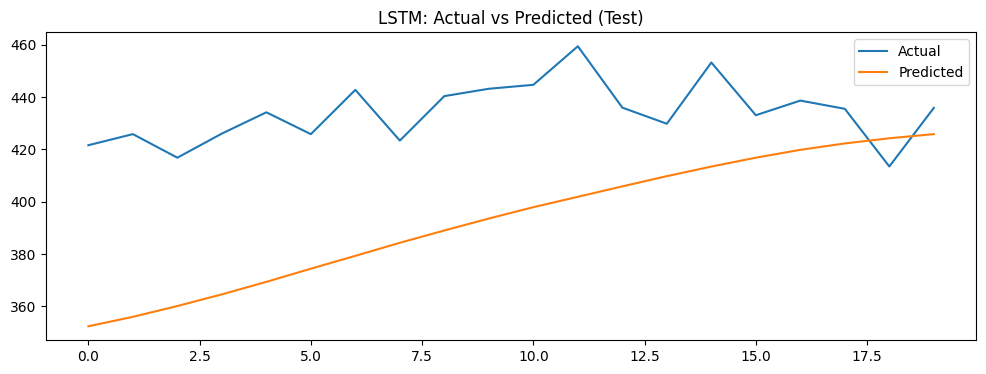

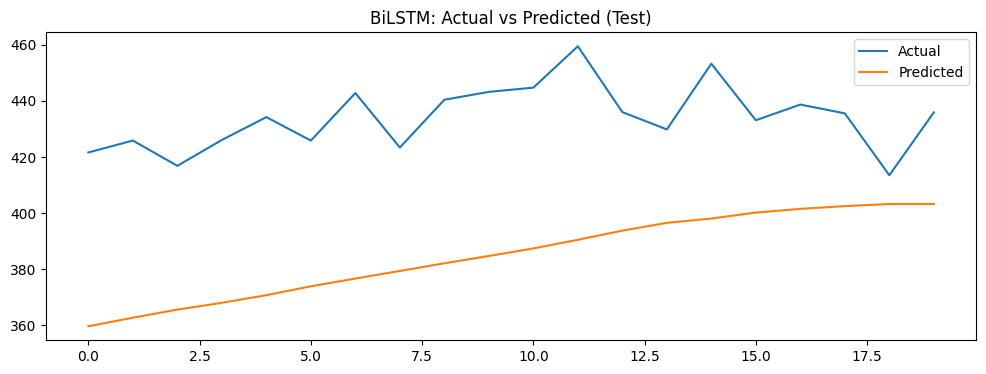

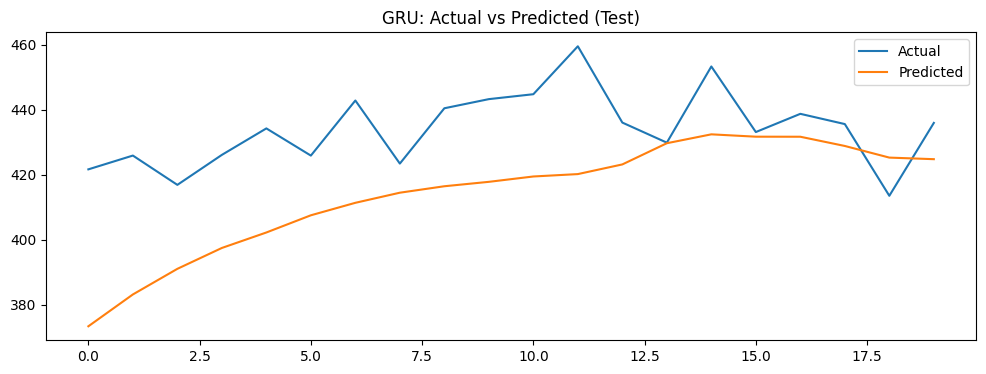

In [24]:
# Cell 17 — plot helper (last N points)
def plot_compare(y_true, preds, title, last_n=200):
    plt.figure(figsize=(12,4))
    plt.plot(y_true[-last_n:], label='Actual')
    plt.plot(preds[-last_n:], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare(y_test_inv, lstm_pred, "LSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, bilstm_pred, "BiLSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, gru_pred, "GRU: Actual vs Predicted (Test)", last_n=200)


In [25]:
# Cell 18 — pick best by RMSE
rmse_dict = {'lstm': lstm_rmse, 'bilstm': bilstm_rmse, 'gru': gru_rmse}
best_name = min(rmse_dict, key=rmse_dict.get)
print("Best model by RMSE:", best_name, rmse_dict)
best_model = {'lstm': lstm, 'bilstm': bilstm, 'gru': gru}[best_name]

Best model by RMSE: gru {'lstm': 46.68859212222585, 'bilstm': 51.17336872338739, 'gru': 24.932710291122902}


In [26]:
# Cell 20 — save best model name explicitly
best_model.save(os.path.join(MODEL_DIR, f"tsla_best_model_{best_name}.h5"))
print("Saved best model:", os.path.join(MODEL_DIR, f"tesla_best_model_{best_name}.h5"))


Saved best model: saved_models\tesla_best_model_gru.h5
